<a href="https://colab.research.google.com/github/vagotec/colab_TF/blob/main/Full_Code_ChatGPT_A_Beginner's_Guide_to_Computer_Vision_with%C2%A0PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating the Dataset

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset


class MyDataset(Dataset):
    def __init__(self, data_dir):
        # Load the CIFAR-10 dataset
        dataset = datasets.CIFAR10(data_dir, train=True, download=True,
                                transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5),
                                                        (0.5, 0.5, 0.5))
                                ]))

        # Split the dataset into training and validation sets
        self.train_data, self.val_data = torch.utils.data.random_split(dataset, [40000, 10000])

    def __getitem__(self, index):
        # Return the data and labels for the specified index
        if index < len(self.train_data):
            data, labels = self.train_data[index]
        else:
            data, labels = self.val_data[index - len(self.train_data)]
        return data, labels

    def __len__(self):
        # Return the number of data samples
        return len(self.train_data) + len(self.val_data)

class MyTestDataset(Dataset):
    def __init__(self, data_dir):
        # Load the CIFAR-10 dataset
        self.test_data = datasets.CIFAR10(data_dir, train=False, download=True,
                                transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5),
                                                        (0.5, 0.5, 0.5))
                                ]))

    def __getitem__(self, index):
        # Return the data and labels for the specified index
        data, labels = self.test_data[index]
        return data, labels

    def __len__(self):
        # Return the number of data samples
        return len(self.test_data)

In [ ]:
from torch.utils.data import DataLoader

# Create the dataset
train_val_dataset = MyDataset("my_datadir")

# Create the dataloader
train_dataloader = DataLoader(train_val_dataset.train_data, batch_size=32, shuffle=True)
val_dataloader = DataLoader(train_val_dataset.val_data, batch_size=32)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting my_datadir/cifar-10-python.tar.gz to my_datadir


# Creating the Network Architecture

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# Define the network architecture
class MyCNN(nn.Module):
  def __init__(self):
    super(MyCNN, self).__init__()

    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.pool = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(64 * 8 * 8, 32)
    self.fc2 = nn.Linear(32, 10)
    self.dropout = nn.Dropout(0.25)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 64 * 8 * 8)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)
    return x

# Training the Network

In [ ]:
num_epochs=3

# Initialize the network
model = MyCNN()

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Use a learning rate scheduler to reduce the learning rate over time
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)

# Train the network
for epoch in range(num_epochs):
  train_loss = 0.0
  train_accuracy = 0.0

  # Train the network on the training set
  for inputs, labels in train_dataloader:
    # Clear the gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(inputs)

    # Compute the loss
    loss = criterion(outputs, labels)

    # Backward pass
    loss.backward()

    # Update the weights
    optimizer.step()

    # Update the training loss and accuracy
    train_loss += loss.item() * inputs.size(0)
    train_accuracy += torch.sum(torch.argmax(outputs, dim=1) == labels)

  # Compute the average training loss and accuracy
  train_loss = train_loss / len(train_val_dataset.train_data)
  train_accuracy = train_accuracy.double() / len(train_val_dataset.train_data)


  # Validate the network on the validation set
  validation_loss = 0.0
  validation_accuracy = 0.0

  with torch.no_grad():
    for inputs, labels in val_dataloader:
      outputs = model(inputs)
      # Compute the loss
      loss = criterion(outputs, labels)

      # Update the validation loss and accuracy
      validation_loss += loss.item() * inputs.size(0)
      validation_accuracy += torch.sum(torch.argmax(outputs, dim=1) == labels)

  # Compute the average validation loss and accuracy
  validation_loss = validation_loss / len(train_val_dataset.val_data)
  validation_accuracy = validation_accuracy.double() / len(train_val_dataset.val_data)

  # Update the learning rate
  scheduler.step(validation_loss)

  # Log the training and validation performance
  print(f'Epoch {epoch + 1}/{num_epochs}:')
  print(f'Training Loss: {train_loss:.4f} - Training Accuracy: {train_accuracy:.4f}')
  print(f'Validation Loss: {validation_loss:.4f} - Validation Accuracy: {validation_accuracy:.4f}')

Epoch 1/3:
Training Loss: 1.5964 - Training Accuracy: 0.4080
Validation Loss: 1.3342 - Validation Accuracy: 0.5096
Epoch 2/3:
Training Loss: 1.2674 - Training Accuracy: 0.5399
Validation Loss: 1.2161 - Validation Accuracy: 0.5601
Epoch 3/3:
Training Loss: 1.1370 - Training Accuracy: 0.5903
Validation Loss: 1.1570 - Validation Accuracy: 0.5840


# Evaluating the Performance

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting my_testdir/cifar-10-python.tar.gz to my_testdir
Accuracy: 0.5885
Precision: 0.0202
Recall: 0.0184
F1 Score: 0.0183
Confusion Matrix:


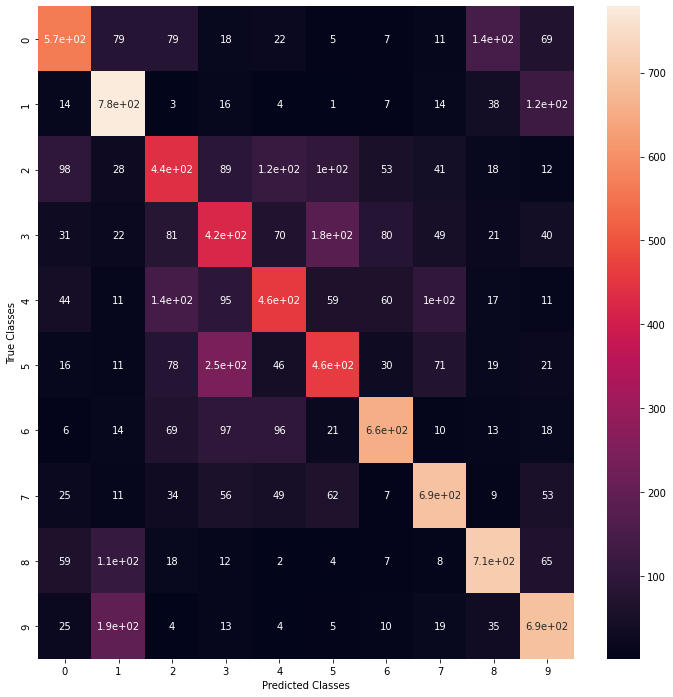

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, f1_score, recall_score

num_classes = 10

# Load the test data
test_dataset = MyTestDataset("my_testdir")
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

# Initialize dictionaries to store the results
results = {'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}
confusion_matrix = torch.zeros(num_classes, num_classes)

with torch.no_grad():
  for inputs, labels in test_dataloader:
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)

    # Update the confusion matrix
    for i in range(inputs.size()[0]):
      confusion_matrix[labels[i], predicted[i]] += 1

    # Compute the accuracy, precision, recall, and F1 score
    results['accuracy'] += torch.sum(predicted == labels)
    results['precision'] += precision_score(labels, predicted, average='weighted', zero_division=0)
    results['recall'] += recall_score(labels, predicted, average='weighted', zero_division=0)
    results['f1'] += f1_score(labels, predicted, average='weighted')

# Compute the average accuracy, precision, recall, and F1 score
num_test_samples = len(test_dataset)
results['accuracy'] /= num_test_samples
results['precision'] /= num_test_samples
results['recall'] /= num_test_samples
results['f1'] /= num_test_samples

# Print the results
print(f'Accuracy: {results["accuracy"]:.4f}')
print(f'Precision: {results["precision"]:.4f}')
print(f'Recall: {results["recall"]:.4f}')
print(f'F1 Score: {results["f1"]:.4f}')

# Print the confusion matrix
print('Confusion Matrix:')
# Plot the confusion matrix
plt.figure(figsize=(12, 12))
ax = sns.heatmap(confusion_matrix, annot=True)
ax.set_xlabel('Predicted Classes')
ax.set_ylabel('True Classes')
plt.show()

# Saving the trained Network

In [ ]:
# Save the entire model to a file
torch.save(model, 'my_model.pt')